In [1]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import os

In [22]:
from autoencoder import AEStyleTransfer

In [3]:
# Get the current working directory
current_directory = os.getcwd()

In [4]:
device='cpu'#'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [5]:
# Define the relative path to the dataset directory
dataset_directory = os.path.join(current_directory, 'datasets')

# Define the filename
filename = 'autoencoder_mixed_mnist_dropout_0.01_60_epochs.pth'

# Combine the directory path and filename to obtain the full path to the file
PATH_PARAMS_AE_PRETRAINED  = os.path.join(dataset_directory, filename)

In [6]:
# Load the pretrained model
pretrained_model_list = torch.load(PATH_PARAMS_AE_PRETRAINED,map_location=torch.device('cpu'))
# this is because the AE was originally trained on GPUs.

# instantiate the model
ae_pretrained= AEStyleTransfer(dropout_prob=0.01)

ae_pretrained.load_state_dict(pretrained_model_list)

<All keys matched successfully>

### Creating encodings

In [7]:
PATH_COLORED_MNIST_TEST= os.path.join(dataset_directory, "colored_rgb_mnist_train.npz")

In [8]:
colored_rgb_test=  np.load(PATH_COLORED_MNIST_TEST)

In [9]:
colored_test_images= torch.tensor(colored_rgb_test['images'])

In [10]:
colored_test_images.shape, type(colored_test_images)

(torch.Size([60000, 28, 28, 3]), torch.Tensor)

In [11]:
torch.max(colored_test_images), torch.min(colored_test_images)

(tensor(1.), tensor(0.))

### Encoded dataset for style transfer

In [12]:
from datasets.custom_encoding_style_transfer import MixedMNIST,encodings_inputs_for_style_transfer,CustomEncodedStyleTransfer

In [13]:
mixed_mnist_data=MixedMNIST(colored_rgb_mnist_dataset=colored_test_images,
                            pre_trained_ae=ae_pretrained)

In [14]:
mixed_image_dataset= mixed_mnist_data.mixed_images

mixed_image_dataset.shape

torch.Size([120000, 28, 28, 3])

In [15]:
mixed_mnist_data.mixed_images_labels.shape

torch.Size([120000])

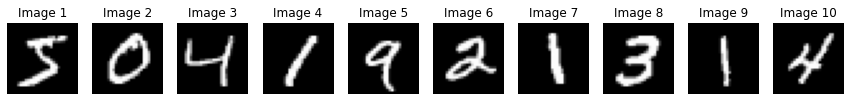

In [16]:
import matplotlib.pyplot as plt
import torch

# Assuming colored_test_images is your tensor
first_5_images = mixed_image_dataset[:10]

# Plot the first 5 images
fig, axes = plt.subplots(1, 10, figsize=(15, 3))  # Adjust figsize as needed
for i in range(10):
    img = first_5_images[i]
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}')

plt.show()

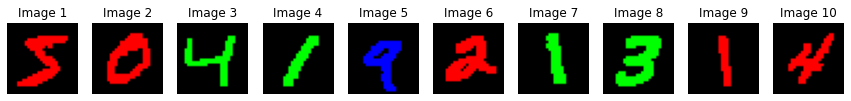

In [17]:
# Assuming colored_test_images is your tensor
first_5_images = mixed_image_dataset[60000:600010]

# Plot the first 5 images
fig, axes = plt.subplots(1, 10, figsize=(15, 3))  # Adjust figsize as needed
for i in range(10):
    img = first_5_images[i]
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}')

plt.show()

In [18]:
### let's create the encodings
check_encodings= encodings_inputs_for_style_transfer(ae_model=ae_pretrained, data= mixed_image_dataset)

In [20]:
check_encodings.shape

torch.Size([120000, 24])

In [ ]:
check=CustomEncodedStyleTransfer(data=check_encodings, labels=mixed_mnist_data.mixed_images_labels)